## Train A Classifier
## What About Data?

通常情况下, 在处理数据的时候可以使用标准的Python包(opencv, skimage等), 并将其载入成Numpy数组的形式, 然后可以很方便的将其转换成torch.*Tensor数据.

对于图像数据来说, PyTorch提供了torchvision包, 它包含许多常见数据集(Imagenet, CIFAR10, MNIST等等)的加载器, 同时还包含其他一些针对图片的数据转换(data transformers)函数. 对于CIFAR10来说, 它的数据集中图片尺寸为 3×32×32, 总共具有10个不同的类别. 下面就来看一下如何训练一个分类器将这10个类别进行分类.

## Training An Image Classifier

接下来主要包括以下步骤:

* 使用torchvision加载并归一化CIFAR10的训练数据集和测试数据集.
* 定义一个卷积神经网络
* 定义损失函数
* 在traing data上训练网络
* 在test datauh测试网络

#### Loading and normalizing CIFAR10:

导入相关的包

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

`torchvision`的输出类型是 PILImage. 我们需要将其转换成 Tensors, 并对其进行归一化, 使其数值处于 [-1, 1] 之间.

In [2]:
# 将多个transforms链接(chained)起来
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


 frog   car   dog   cat


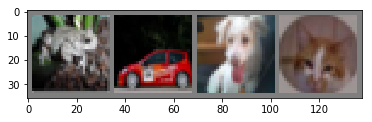

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2) # 两个max pooling的参数是一样的, 所以定义一个就行, 可以重复使用
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, input):
        x = self.pool(F.relu(self.conv1(input)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5) # 第一个维度为batch size
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output = self.fc3(x)
        return output

net = Net()

### Define a Loss function and optimizer:
损失函数使用交叉熵, 优化器使用带动量的SGD

In [5]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 训练网络:
训练网络的时候, 我们需要简单的在数据迭代器上进行循环操作就可以, 只需要注意不断想网络中送入新的数据即可.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) # 输出 cdua

cuda


In [7]:
net = net.to(device)

In [8]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.162
[1,  4000] loss: 1.863
[1,  6000] loss: 1.670
[1,  8000] loss: 1.570
[1, 10000] loss: 1.510
[1, 12000] loss: 1.478
[2,  2000] loss: 1.402
[2,  4000] loss: 1.376
[2,  6000] loss: 1.368
[2,  8000] loss: 1.331
[2, 10000] loss: 1.316
[2, 12000] loss: 1.280
Finished Training


### Test the network on the test data
在测试集上获取模型的准确率, 只需要利用outputs = net(images)即可获得预测的类别概率, 取最大者为预测的类别结果.

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


利用下面的代码可以看到每个类别的准确率:

In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 46 %
Accuracy of   car : 86 %
Accuracy of  bird : 43 %
Accuracy of   cat : 44 %
Accuracy of  deer : 45 %
Accuracy of   dog : 41 %
Accuracy of  frog : 68 %
Accuracy of horse : 64 %
Accuracy of  ship : 62 %
Accuracy of truck : 44 %


## Training on GPU
上面的代码是在CPU上训练的, 那么如何利用PyTorch在GPU上进行训练呢? 实际上, 只需要将模型转移到GPU上即可. 首先定义一个device对象:

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) # 输出 cdua

cuda


In [7]:
torch.cuda.device_count()

1

接下来, 利用.to()方法将模型转移到GPU上面(同时所有的参数和梯度缓存也会转移到GPU上)

In [ ]:
net.to(device) # 也可以直接写成 net.to(device), 但是这样会缺少了设备检查, 不够健壮

In [ ]:
inputs, labels = inputs.to(device), labels.to(device)